In [480]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import warnings
from DTW import min_dis
%matplotlib inline

warnings.filterwarnings(action='ignore')



def data(cat):
    ####data process###
    ##interday data
    p_df_inter = pd.read_csv('/Users/liyuefan/Documents/gtja/%sFI_0331.csv'%cat.upper(), encoding='gbk')
    p_df_inter['update_date'] = pd.to_datetime(p_df_inter['update_date'])
    p_df_inter['update_date'] = pd.to_datetime(p_df_inter['update_date'].apply(lambda x: x.date()))
    p_df_inter.index = [p_df_inter['update_date']]
    p_df_inter = p_df_inter.drop(['update_date'], axis=1)

    # intraday data
    p_df_intra = pd.read_csv('/Users/liyuefan/Documents/gtja/%s_intraday_2year.csv'%cat.upper(), encoding='gbk')
    p_df_intra['update_date'] = pd.to_datetime(p_df_intra['update_date'])
    p_df_intra = p_df_intra[p_df_intra['update_date'].apply(lambda x: x.hour) >= 9][p_df_intra['update_date'].apply(lambda x: x.hour) <= 15]
    p_df_intra['date'] = pd.to_datetime(p_df_intra['update_date'].apply(lambda x: x.date()))
    # select the certain minute in a day for trading.
    p_df_intra_ = pd.DataFrame()
    c_df_intra_ = pd.DataFrame()
    for i, j in p_df_intra.groupby(['date']):
        j = j.sort(['update_date'])
        t = j.iloc[5, :]
        l = j.iloc[-1, :]
        p_df_intra_ = p_df_intra_.append(t)
        c_df_intra_ = c_df_intra_.append(l)
    p_df_intra_['date'] = pd.to_datetime(p_df_intra_['date'])
    c_df_intra_['date'] = pd.to_datetime(c_df_intra_['date'])

    p_df_intra = p_df_intra_
    c_df_intra = c_df_intra_

    p_df_intra.index = [p_df_intra['date']]
    c_df_intra.index = [c_df_intra['date']]

    p_df_intra = p_df_intra.drop(['update_date', 'date'], axis=1)
    c_df_intra = c_df_intra.drop(['update_date', 'date'], axis=1)

    p_df_intra = p_df_intra[['close']]
    c_df_intra = c_df_intra[['close']]

    p_df_intra = p_df_intra.rename(columns={'close': 'open'})


    p_df = pd.concat([p_df_inter[['high', 'low', 'close']], p_df_intra[['open']]], axis=1, join='inner')
    p_df = pd.concat([p_df, c_df_intra], axis=1, join='inner')

    # LME data
    lme_df = pd.read_excel('/Users/liyuefan/Documents/gtja/LME_%s.xlsx'%cat.upper(), sheetname='LME')
    N_col = lme_df.shape[1]
    update_date = lme_df.iloc[3:, 0]
    lme_df_ = pd.DataFrame()
    lme_df_['update_date'] = update_date
    for i in range(1, N_col, 2):
        indicator_name = lme_df.iloc[1, i]
        data = lme_df.iloc[3:, i]
        lme_df_[indicator_name] = data

    lme_df = lme_df_
    lme_df['update_date'] = pd.to_datetime(lme_df['update_date'])
    lme_df=lme_df.dropna(axis=0)
    lme_df.index = [lme_df['update_date']]
    lme_df = lme_df.drop(['update_date'], axis=1)
    lme_df = lme_df.apply(lambda x: x.astype(float), axis=1)

    # lme_df['NON-COMMERCIAL LONG PERCENTAGE']=lme_df['NON-COMMERCIAL LONG']/lme_df['OPEN INTEREST']
    # lme_df['NON-COMMERCIAL SHORT PERCENTAGE']=lme_df['NON-COMMERCIAL SHORT']/lme_df['OPEN INTEREST']
    # lme_df['COMMERCIAL SHORT PERCENTAGE']=lme_df['COMMERCIAL SHORT']/lme_df['OPEN INTEREST']
    # lme_df['COMMERCIAL LONG PERCENTAGE']=lme_df['COMMERCIAL LONG']/lme_df['OPEN INTEREST']
    # lme_df['NET NON-COMMERCIAL PERCENTAGE']=lme_df['NON-COMMERCIAL LONG PERCENTAGE']-lme_df['NON-COMMERCIAL SHORT PERCENTAGE']

    # THIS IS THE X IN REGRESSION
    lme_df['NET_COMM_PER'] = (lme_df['NON-COMMERCIAL LONG'] - lme_df['NON-COMMERCIAL SHORT']) / lme_df['OPEN INTEREST']
#     lme_df['NET_COMM_PER'] = lme_df['NET_COMM_PER'].fillna(method='ffill')
    # CFTC data
    cftc = pd.read_csv('/Users/liyuefan/Documents/gtja/CFTC_CU.csv', encoding='gbk', thousands=',')

    cftc_data = cftc.iloc[1:, :]
    cftc_cln = pd.DataFrame(cftc_data)
    cftc_cln.columns = ['update_date', 'non_comm_long', 'non_comm_short', 'non_comm_arb', 'comm_long', 'comm_short',
                        'open_interest']
    cftc_cln = cftc_cln.dropna(axis=0)
    cftc_cln['update_date'] = pd.to_datetime(cftc_cln['update_date'])


    def thousands(series):
        return series.str.replace(',', '').astype(float)


    for col in cftc_cln.columns:
        if col != 'update_date':
            cftc_cln[col] = thousands(cftc_cln[col])
        else:
            pass

    cftc_cln['non_comm_net'] = cftc_cln['non_comm_long'] - cftc_cln['non_comm_short']
    # THIS IS THE Y IN REGRESSION
    cftc_cln['non_comm_per'] = cftc_cln['non_comm_net'] / cftc_cln['open_interest']
    cftc_cln.index = [cftc_cln['update_date']]
    cftc_cln = cftc_cln.drop(['update_date'], axis=1)
    cftc_cln['report_date'] = pd.to_datetime(cftc_cln.index + np.timedelta64(4, 'D'))
    return cftc_cln,lme_df,p_df



def decision(date,cftc_cln,lme_df,p_df,dir_last):
    date=pd.to_datetime(date)
    cftc_cln=cftc_cln[cftc_cln['report_date']<date]
    lme_df=lme_df[lme_df.index<date]
    p_df=p_df[p_df.index<date]
    ln = 60
    if len(lme_df)>=ln and len(cftc_cln)>=30:
        regr_df = pd.concat([lme_df[['NET_COMM_PER']], cftc_cln[['non_comm_per']]], axis=1, join='inner')

        regr_df = regr_df.dropna(axis=0)


        #calculation of cftc_estimation
        X = np.array(regr_df['NET_COMM_PER'])
        X = sm.add_constant(X)
        Y = np.array(regr_df['non_comm_per'])
        X=X[-29:,]
        Y=Y[-29:,]
        lm=sm.OLS(Y,X)
        result=lm.fit()
        const=result.params[0]
        coef=result.params[1]


        df_all=pd.DataFrame()
        df_all['update_date']=lme_df.index
        # lme_df['cftc']=lme_df['NET_COMM_PER']*coef+const
        # df_all['cftc']=lme_df['cftc'].values
        df_all['cftc']=lme_df['NET_COMM_PER'].values
        df_all.index=[df_all['update_date']]
        df_all=df_all.drop(['update_date'],axis=1)
        #the analysis on lme and cftc completed, nxt deal with price(p_df)
        df_all=pd.concat([df_all,p_df],axis=1,join='inner')
#         df_all['cftc']=df_all['cftc'].fillna(method='ffill')
        df_all['open_ma']=pd.rolling_mean(df_all['open'],20)
        df_all['cftc_ma']=pd.rolling_mean(df_all['cftc'],5)
        df_all['open_ma_diff'] = df_all['open_ma'].diff()
        df_all['cftc_ma_diff'] = df_all['cftc_ma'].diff()
        p=0.6
        pp=0.8
        p_=1-p
        pp_=1-pp

#         df_all['o_up_thr'] = pd.rolling_quantile(df_all['open_ma_diff'], ln, p)
#         df_all['o_low_thr'] = pd.rolling_quantile(df_all['open_ma_diff'], ln, p_)
        df_all['o_up_thr']=pd.rolling_mean(df_all['open_ma_diff'],ln)+0.5*pd.rolling_std(df_all['open_ma_diff'],ln)
        df_all['o_low_thr']=pd.rolling_mean(df_all['open_ma_diff'],ln)-0.5*pd.rolling_std(df_all['open_ma_diff'],ln)
#         df_all['cftc_up_thr'] = pd.rolling_quantile(df_all['cftc_ma_diff'], ln, pp)
#         df_all['cftc_low_thr'] = pd.rolling_quantile(df_all['cftc_ma_diff'], ln, pp_)
        df_all['cftc_up_thr']=pd.rolling_mean(df_all['cftc_ma_diff'],ln)+0.5*pd.rolling_std(df_all['cftc_ma_diff'],ln)
        df_all['cftc_low_thr']=pd.rolling_mean(df_all['cftc_ma_diff'],ln)-0.5*pd.rolling_std(df_all['cftc_ma_diff'],ln)

        def cc_2(x, u, l):
            if x >= u:
                return 1
            elif x <= l:
                return -1
            else:
                return 0

        df_all['open_ma_sig'] = map(cc_2, df_all['open_ma_diff'], df_all['o_up_thr'], df_all['o_low_thr'])
        df_all['cftc_ma_sig'] = map(cc_2, df_all['cftc_ma_diff'], df_all['cftc_up_thr'], df_all['cftc_low_thr'])
        def sig(x, y):
            if x != 0 and y==0:
                return x
            elif x==0 and y!=0:
                return 0

            else:
                return dir_last

        df_all['dir'] = map(sig, df_all['open_ma_sig'], df_all['cftc_ma_sig'])
        if len(df_all)>0:
            today=df_all.iloc[-1,:]
            today_dir=today['dir']
            if today['open_ma_sig']==today['cftc_ma_sig'] and today_dir!=0:
                trend=1
            elif today['open_ma_sig']!=today['cftc_ma_sig'] and today_dir!=0:
                trend=0
            else:
                trend=np.nan

            return today_dir,trend
        else:
            return np.nan,np.nan
    else:
        return np.nan,np.nan



In [481]:
def decision_v2(date,lme_df,p_df):
    lme_df=lme_df[lme_df['update_date']<date]
    p_df=p_df[p_df['update_date']<date]
    

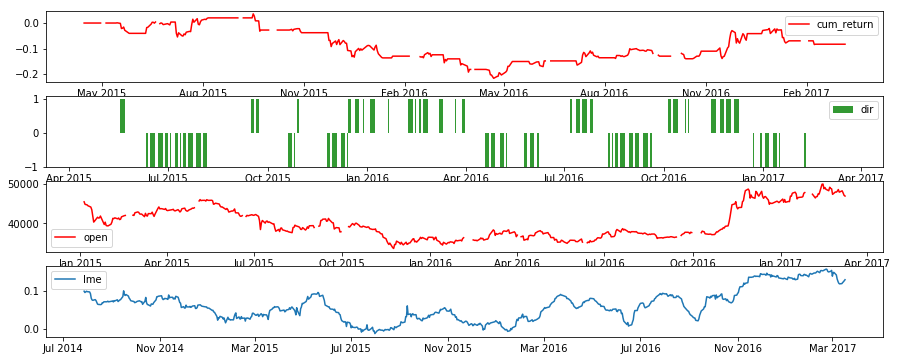

In [484]:
cat='cu'
cftc_cln,lme_df,p_df=data(cat)
back_test_date_list=list(lme_df.index)
p_df['r']=np.log(p_df['open'])
p_df['r']=p_df['r'].diff()
p_df['r']=p_df['r'].shift(-1)
result_df=pd.DataFrame()
result_df['update_date']=back_test_date_list
result_df['dir']=0
result_df['daily_r']=0
col_list=list(result_df.columns)
dir_index=col_list.index('dir')
daily_r_index=col_list.index('daily_r')
daily_r_l=list()
dir_l=list()
trend_l=list()
dir_last=0
for date in back_test_date_list:
    dir_, trend = decision(date, cftc_cln, lme_df, p_df,dir_last)
    p_df_today=p_df[p_df.index==date]['r'].values
    if len(p_df_today)>0:
        r=p_df_today[0]
    else:
        r=np.nan
    daily_r=dir_*r
    dir_l.append(dir_)
    trend_l.append(trend)
    daily_r_l.append(daily_r)
    dir_last=dir_
result_df['dir']=dir_l

# result_df['dir']=result_df['dir'].fillna(method='ffill')


result_df['daily_r']=daily_r_l
result_df['sig_typ']=trend_l
result_df['cum_r']=result_df['daily_r'].cumsum()



result_df.index=[result_df['update_date']]
plt.figure(figsize=(15,6))
plt.subplot(4,1,1)
plt.plot(lme_df.index,result_df['cum_r'][lme_df.index],label='cum_return',color='red')
plt.legend()
plt.subplot(4,1,2)
plt.bar(lme_df.index,result_df['dir'][lme_df.index],color='green',alpha=0.8,label='dir')
plt.legend()
plt.subplot(4,1,3)
plt.plot(lme_df.index,p_df['open'][lme_df.index],color='red',label='open')
plt.legend()
plt.subplot(4,1,4)
plt.plot(lme_df.index,np.log(lme_df['NET_COMM_PER'][lme_df.index]+1),label='lme')
plt.legend()
plt.show()

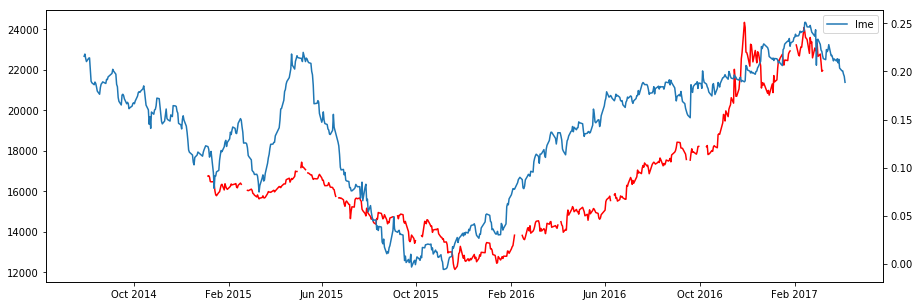

In [479]:
plt.figure(figsize=(15,5))
plt.plot(lme_df.index,p_df['open'][lme_df.index],color='red',label='open')
ax2=plt.twinx()
ax2.plot(lme_df.index,lme_df['NET_COMM_PER'][lme_df.index],label='lme')
plt.legend()

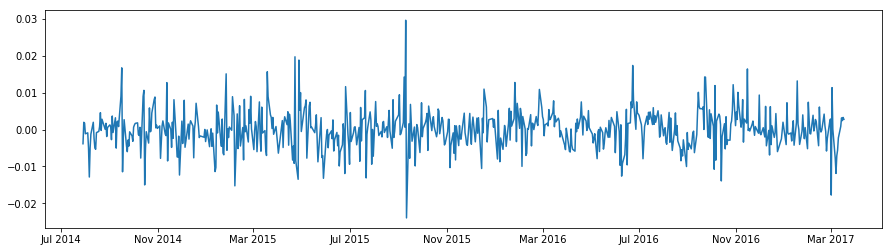

In [454]:
plt.figure(figsize=(15,4))
plt.plot(lme_df.index,lme_df['NET_COMM_PER'].diff()[lme_df.index])